In [1]:
import pandas as pd
import pandas as pd
from tensorflow.keras.optimizers import Adam
import numpy as np
import tensorflow as tf

from scipy import stats
from sklearn.preprocessing import StandardScaler

In [2]:
import sys
sys.path.append('..')
from xDL.models.FTTransformer import FTTransformer

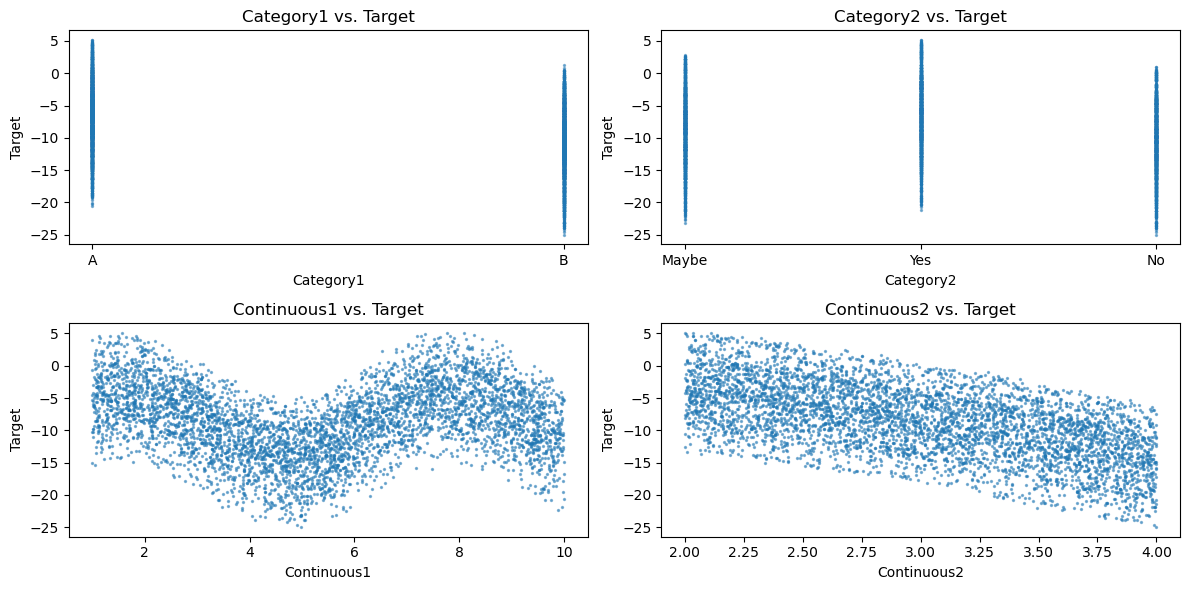

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set a random seed for reproducibility
np.random.seed(42)

# Number of data points
num_samples = 5000

# Define a list of possible categorical values
categories = ['A', 'B']

# Generate random categorical data as an array of strings
categorical1 = np.random.choice(categories, size=num_samples)

categories = ['Yes', 'No', 'Maybe']
categorical2 = np.random.choice(categories, size=num_samples)

# Generate the input variable X as a random draw from a linspace
X1 = np.random.uniform(1, 10, size=num_samples)
X2 = np.random.uniform(2, 4, size=num_samples)

# Generate continuous variables as a function of X with noise dependent on X
def func1(x):
    return 5*np.sin(x) + np.random.normal(0, 0.005 + 0.05 * x, size=len(x)) 

def func2(x):
    return -x**2 + np.random.normal(0, 0.1 + 0.05 * x, size=len(x))


# Create mappings for categorical values
category_map1 = {'A': 2, 'B': -2}
category_map2 = {'Yes': 2, 'No': -2, 'Maybe': 0}

# Calculate y by combining continuous and categorical functions
y = func1(X1) + func2(X2) + np.vectorize(category_map1.get)(categorical1) + np.vectorize(category_map2.get)(categorical2)

data = pd.DataFrame({"Target": y, 'Category1': categorical1, 'Category2': categorical2, 'Continuous1':X1, 'Continuous2':X2})

# Plot each input variable against the target variable
plt.figure(figsize=(12, 6))

for i, column in enumerate(['Category1', 'Category2', 'Continuous1', 'Continuous2'], 1):
    plt.subplot(2, 2, i)
    plt.scatter(data[column], data['Target'], alpha=0.5, s=2)
    plt.title(f'{column} vs. Target')
    plt.xlabel(column)
    plt.ylabel('Target')

plt.tight_layout()
plt.show()


In [4]:
data.head()

,Target,Category1,Category2,Continuous1,Continuous2
0,-2.870165,A,Maybe,8.586509,2.988086
1,-10.346173,B,Maybe,5.012980,2.110435
2,-9.506375,A,Maybe,7.377252,3.909275
3,1.529260,A,Maybe,7.586855,2.257155
4,-6.620087,A,Maybe,2.565673,3.394923


In [5]:
model = FTTransformer(
    data=data, 
    y="Target",
    output_activation="linear",
    binning_task="regression",
    num_encoding="PLE",
    n_bins_num=15
    )

In [6]:
model.data

,Target,Category1,Category2,Continuous1,Continuous2
0,-2.870165,A,Maybe,8.586509,2.988086
1,-10.346173,B,Maybe,5.012980,2.110435
2,-9.506375,A,Maybe,7.377252,3.909275
3,1.529260,A,Maybe,7.586855,2.257155
4,-6.620087,A,Maybe,2.565673,3.394923
...,...,...,...,...,...
4995,-9.569279,A,Maybe,6.196076,3.359352
4996,-12.611797,B,Maybe,9.007618,3.425918
4997,-10.681787,A,No,7.302757,3.870685
4998,-7.181862,B,No,2.815300,2.129747


In [7]:
import numpy as np
dataset = model.data.copy()
dataset["Category1"] = np.zeros(len(dataset), dtype=int)
dataset["Category2"] = np.zeros(len(dataset), dtype=int)
dataset["Continuous2"] = np.zeros(len(dataset), dtype=int)
dataset["Continuous1"] = np.linspace(data["Continuous1"].min(), data["Continuous1"].max(), len(dataset))

from xDL.utils.data_utils import *

dataset = df_to_dataset(
            dataset,
            model.data,
            model.input_dict,
            model.y,
            batch_size=1024,
            shuffle=False,
            feature_information=model.feature_information,
            task=model.binning_task,
        )

In [8]:
model.encoder

In [9]:
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer = optimizer,
    loss = {"output": "mse", "importances": None, "att_weights": None},
    metrics= {"output": "mse", "importances": None, "att_weights": None},)

history = model.fit(
    model.training_dataset, 
    epochs=20, 
    validation_data=model.validation_dataset,
    verbose=1
)

Epoch 1/20


[<tf.Tensor 'ft_transformer/ft_transformer_encoder/embedding/embedding_lookup/Identity:0' shape=(None, 1, 32) dtype=float32>, <tf.Tensor 'ft_transformer/ft_transformer_encoder/embedding_1/embedding_lookup/Identity:0' shape=(None, 1, 32) dtype=float32>]
Tensor("ft_transformer/ft_transformer_encoder/concat:0", shape=(None, 5, 32), dtype=float32)
[<tf.Tensor 'ft_transformer/ft_transformer_encoder/embedding/embedding_lookup/Identity:0' shape=(None, 1, 32) dtype=float32>, <tf.Tensor 'ft_transformer/ft_transformer_encoder/embedding_1/embedding_lookup/Identity:0' shape=(None, 1, 32) dtype=float32>]


ValueError: in user code:

    File "c:\Users\anton\anaconda3\envs\namlss_venv\Lib\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\anton\anaconda3\envs\namlss_venv\Lib\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\anton\anaconda3\envs\namlss_venv\Lib\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\anton\anaconda3\envs\namlss_venv\Lib\site-packages\keras\src\engine\training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\anton\anaconda3\envs\namlss_venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\anton\AppData\Local\Temp\__autograph_generated_file5d0nmc7r.py", line 64, in tf__call
        ag__.if_stmt(ag__.ld(self).encoder.explainable, if_body_1, else_body_1, get_state_1, set_state_1, ('do_return', 'retval_'), 2)
    File "C:\Users\anton\AppData\Local\Temp\__autograph_generated_file5d0nmc7r.py", line 20, in if_body_1
        x, expl = ag__.converted_call(ag__.ld(self).encoder, (ag__.ld(inputs),), None, fscope)
    File "C:\Users\anton\AppData\Local\Temp\__autograph_generated_file0vslavd4.py", line 40, in tf__call
        ag__.for_stmt(ag__.converted_call(ag__.ld(enumerate), (ag__.ld(self).num_features,), None, fscope), None, loop_body_1, get_state_1, set_state_1, (), {'iterate_names': '(i, c)'})
    File "C:\Users\anton\AppData\Local\Temp\__autograph_generated_file0vslavd4.py", line 36, in loop_body_1
        embeddings = ag__.converted_call(ag__.converted_call(ag__.ld(tf).keras.layers.Dense, (ag__.ld(self).embedding_dim,), dict(activation='relu'), fscope), (ag__.ld(inputs)[ag__.ld(c)],), None, fscope)

    ValueError: Exception encountered when calling layer 'ft_transformer' (type FTTransformer).
    
    in user code:
    
        File "c:\Users\anton\Desktop\Projects\xDL\examples\..\xDL\models\FTTransformer.py", line 154, in call  *
            x, expl = self.encoder(inputs)
        File "c:\Users\anton\anaconda3\envs\namlss_venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "C:\Users\anton\AppData\Local\Temp\__autograph_generated_file0vslavd4.py", line 40, in tf__call
            ag__.for_stmt(ag__.converted_call(ag__.ld(enumerate), (ag__.ld(self).num_features,), None, fscope), None, loop_body_1, get_state_1, set_state_1, (), {'iterate_names': '(i, c)'})
        File "C:\Users\anton\AppData\Local\Temp\__autograph_generated_file0vslavd4.py", line 36, in loop_body_1
            embeddings = ag__.converted_call(ag__.converted_call(ag__.ld(tf).keras.layers.Dense, (ag__.ld(self).embedding_dim,), dict(activation='relu'), fscope), (ag__.ld(inputs)[ag__.ld(c)],), None, fscope)
    
        ValueError: Exception encountered when calling layer 'ft_transformer_encoder' (type FTTransformerEncoder).
        
        in user code:
        
            File "c:\Users\anton\Desktop\Projects\xDL\examples\..\xDL\backend\transformer_encoder.py", line 325, in call  *
                embeddings = tf.keras.layers.Dense(self.embedding_dim, activation="relu")(
            File "c:\Users\anton\anaconda3\envs\namlss_venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler  **
                raise e.with_traceback(filtered_tb) from None
        
            ValueError: tf.function only supports singleton tf.Variables created on the first call. Make sure the tf.Variable is only created once or created outside tf.function. See https://www.tensorflow.org/guide/function#creating_tfvariables for more information.
        
        
        Call arguments received by layer 'ft_transformer_encoder' (type FTTransformerEncoder):
          • inputs={'Category1': 'tf.Tensor(shape=(None, 1), dtype=int64)', 'Category2': 'tf.Tensor(shape=(None, 1), dtype=int64)', 'Continuous1': 'tf.Tensor(shape=(None, 15), dtype=float32)', 'Continuous2': 'tf.Tensor(shape=(None, 15), dtype=float32)'}
    
    
    Call arguments received by layer 'ft_transformer' (type FTTransformer):
      • inputs={'Category1': 'tf.Tensor(shape=(None, 1), dtype=int64)', 'Category2': 'tf.Tensor(shape=(None, 1), dtype=int64)', 'Continuous1': 'tf.Tensor(shape=(None, 15), dtype=float32)', 'Continuous2': 'tf.Tensor(shape=(None, 15), dtype=float32)'}


<Figure size 1200x400 with 0 Axes>

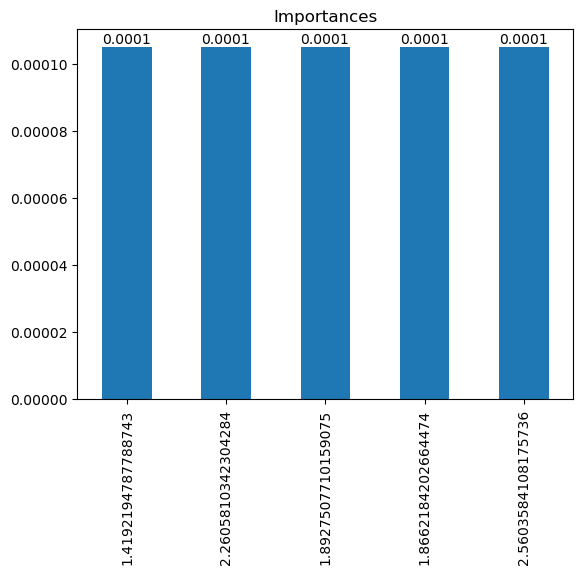

In [ ]:
model.plot_categorical_importances()

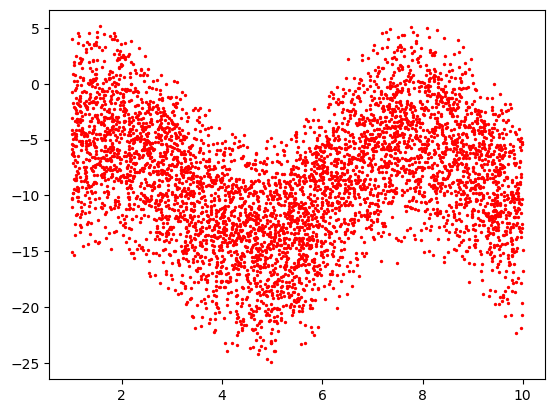

In [ ]:
plt.scatter(model.data["Continuous1"], model.data["Target"], s=2, color="red")

In [ ]:
model.data

,Target,Category1,Category2,Continuous1,Continuous2
0,-2.870165,A,Maybe,8.586509,2.988086
1,-10.346173,B,Maybe,5.012980,2.110435
2,-9.506375,A,Maybe,7.377252,3.909275
3,1.529260,A,Maybe,7.586855,2.257155
4,-6.620087,A,Maybe,2.565673,3.394923
...,...,...,...,...,...
4995,-9.569279,A,Maybe,6.196076,3.359352
4996,-12.611797,B,Maybe,9.007618,3.425918
4997,-10.681787,A,No,7.302757,3.870685
4998,-7.181862,B,No,2.815300,2.129747


5/5 [==============================] - 1s 140ms/step


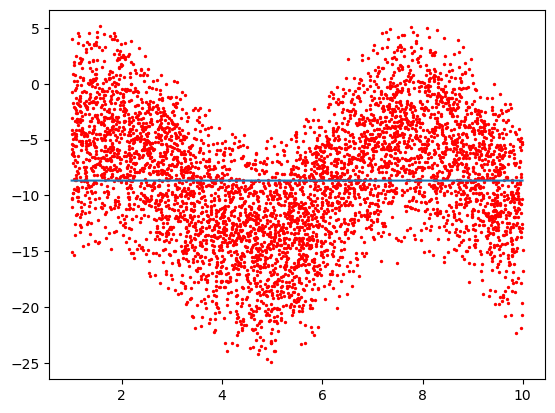

In [ ]:
import matplotlib.pyplot as plt
preds = model.predict(dataset)
preds = preds["output"].squeeze()

plt.scatter(model.data["Continuous1"], model.data["Target"], s=2, color="red")
plt.plot(np.linspace(data["Continuous1"].min(), data["Continuous1"].max(), len(preds)), preds)

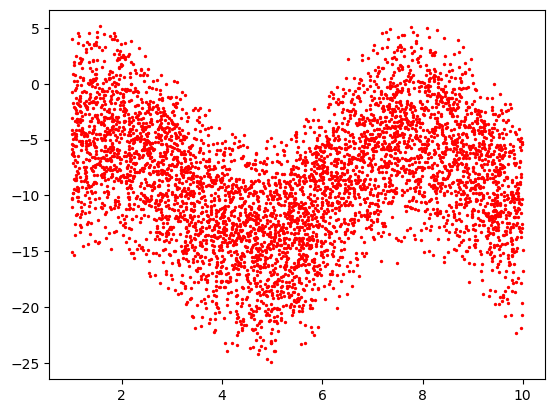

In [ ]:
plt.scatter(model.data["Continuous1"], model.data["Target"], s=2, color="red")